In [2]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 81.8 MB/s eta 0:00:00:00:01


In [52]:
import json
import gzip
import math
import numpy as np
import random
import statistics
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
import datetime
from tqdm import tqdm
import sys
import warnings
import lightgbm as lgbm
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore")
sns.set_style("white")

In [6]:
event_df = pd.read_csv('train_logs.csv.zip')
event_df

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [7]:
score_df = pd.read_csv('train_scores.csv')
score_df = score_df.set_index('id')
score_df

,score
id,
001519c8,3.5
0022f953,3.5
0042269b,6.0
0059420b,2.0
0075873a,4.0
...,...
ffb8c745,3.5
ffbef7e5,4.0
ffccd6fd,1.5


# Exploratory Data Analysis

I chose this data due to my personal interest in the use of typing patterns as indicators of certain behaviors, and this was a great way to understand the structure / nature of most typing data sets & train models on them. 

## First, let's look at the distribution of scores

We are trying to predict essay scores, so let's examine scores of essays

Text(0.5, 1.0, 'Essay Score Distribution')

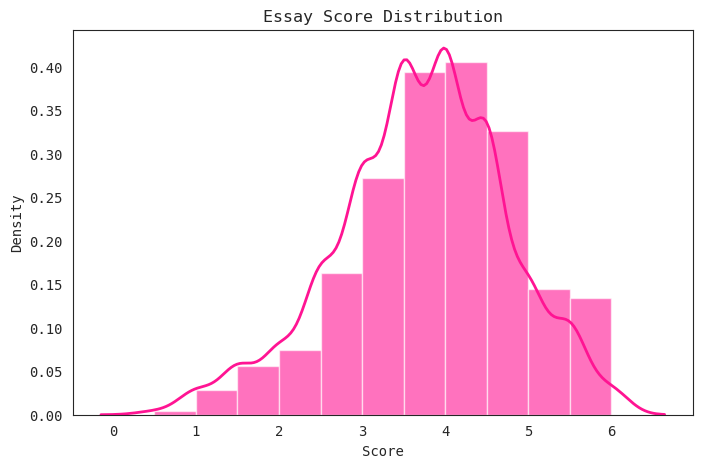

In [8]:
sns.set_style("white")
plt.rcParams['font.family'] = 'monospace' 
# Import data
x1 = score_df['score']

# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2}, bins=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6])
 
plt.figure(figsize=(8,5), dpi= 100)



sns.distplot(x1, color="deeppink", **kwargs)

plt.xlabel("Score")
plt.ylabel("Density")
plt.title("Essay Score Distribution")

## Let's create some more basic features: the number of events and number of deletions in an essay

In [9]:
## Functions for basic features:
def num_events(essay_id, df):
    ft_df = df[essay_id]
    return len(ft_df)

def num_deletions(essay_id, df):
    counts =  df[essay_id]['activity'].value_counts()
    if 'Remove/Cut' in counts.index:
        return counts['Remove/Cut']
    else:
        return 0

def num_words(essay_id, df):
    count = df[essay_id]['word_count'].iloc[-1]
    return count

In [10]:
## Create a dict of essay id to pandas dataframe - easy to get a specific dataframe's essay for feature extraction
essay_events = dict(tuple(event_df.groupby('id')))

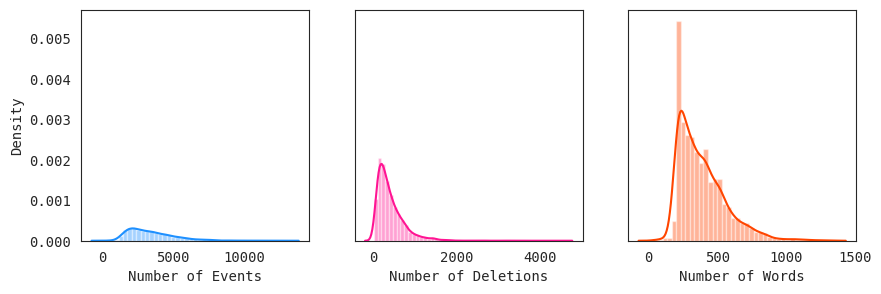

In [11]:
x1 = [num_events(index, essay_events) for index, row in score_df.iterrows()]
x2 = [num_deletions(index, essay_events) for index, row in score_df.iterrows()]
x3 = [num_words(index, essay_events) for index, row in score_df.iterrows()]

# plot
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, dpi=100)
sns.distplot(x1 , color="dodgerblue", ax=axes[0], axlabel='Number of Events')
sns.distplot(x2 , color="deeppink", ax=axes[1], axlabel='Number of Deletions');
sns.distplot(x3 , color="orangered", ax=axes[2], axlabel='Number of Words');

## These distributions are clearly log-scaled, so let's make features that take the log of both of them

In [12]:
def log_num_events(essay_id, df):
    return math.log2(num_events(essay_id, df))

def log_num_deletions(essay_id, df):
    return math.log2(num_deletions(essay_id, df) + 1) # offset for log

def log_num_words(essay_id, df):
    return math.log2(num_words(essay_id, df))

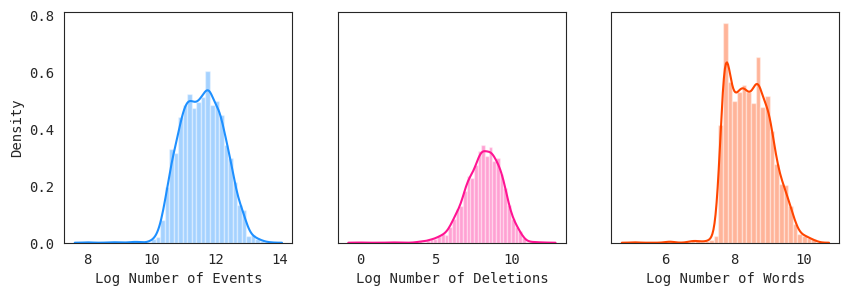

In [13]:
x1 = [log_num_events(index, essay_events) for index, row in score_df.iterrows()]
x2 = [log_num_deletions(index, essay_events) for index, row in score_df.iterrows()]
x3 = [log_num_words(index, essay_events) for index, row in score_df.iterrows()]

# plot
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, dpi=100)
sns.distplot(x1 , color="dodgerblue", ax=axes[0], axlabel='Log Number of Events')
sns.distplot(x2 , color="deeppink", ax=axes[1], axlabel='Log Number of Deletions');
sns.distplot(x3 , color="orangered", ax=axes[2], axlabel='Log Number of Words');

# Prediction

## Naive Approach (Linear Regression)

The dataset has keystrokes from users, but the keys are anonymized as 'q' so the goal is to use the timestamps / ordering of events to train some model to predict the score of each essay. There are about 2500 users' essays in the dataset and nearly 8.5 million events, so I'll definitely have to drastically reduce dimensionality when I do regular classification. For now, though, we can see if we can fit a regression between # of events and the score for each essay.

In [14]:
def MSE(predictions, actual):
    return sum((predictions[i] - actual[i])**2 for i in range(len(predictions))) / len(predictions)

In [15]:
## Train / Valid / Test Split:
seeds = 2004, 1983, 12

splits = [np.split(
    score_df.sample(frac=1, random_state = seed), [int(0.5 * len(score_df))]) for seed in seeds]

train_score_dfs = [split[0] for split in splits]
test_score_dfs = [split[1] for split in splits]

In [16]:
## All features separate: log and not log

X_trains_num_events = [[[num_events(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]
X_trains_log_num_events = [[[log_num_events(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]
X_trains_num_deletions = [[[num_deletions(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]
X_trains_log_num_deletions = [[[log_num_deletions(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]
X_trains_num_words = [[[num_words(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]
X_trains_log_num_words = [[[log_num_words(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]

y_trains = [[row['score'] for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]


X_tests_num_events = [[[num_events(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]
X_tests_log_num_events = [[[log_num_events(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]
X_tests_num_deletions = [[[num_deletions(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]
X_tests_log_num_deletions = [[[log_num_deletions(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]
X_tests_num_words = [[[num_words(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]
X_tests_log_num_words = [[[log_num_words(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]


y_tests = [[row['score'] for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]

In [17]:
regs_num_events = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_num_events, y_trains)]

regs_log_num_events = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_log_num_events, y_trains)]

regs_num_deletions = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_num_deletions, y_trains)]

regs_log_num_deletions = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_log_num_deletions, y_trains)]

regs_num_words = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_num_words, y_trains)]

regs_log_num_words = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_log_num_words, y_trains)]

In [18]:
y_preds_num_events = [reg.predict(X_test) for (reg, X_test) in zip(regs_num_events, X_tests_num_events)]
MSE_num_events = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_num_events, y_tests)]
print(f"MSES for num events: {MSE_num_events}") 

y_preds_log_num_events = [reg.predict(X_test) for (reg, X_test) in zip(regs_log_num_events, X_tests_log_num_events)]
MSE_log_num_events = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_log_num_events, y_tests)]
print(f"MSES for log num events: {MSE_log_num_events}") 

y_preds_num_deletions = [reg.predict(X_test) for (reg, X_test) in zip(regs_num_deletions, X_tests_num_deletions)]
MSE_num_deletions = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_num_deletions, y_tests)]
print(f"MSES for num deletions: {MSE_num_deletions}") 

y_preds_log_num_deletions = [reg.predict(X_test) for (reg, X_test) in zip(regs_log_num_deletions, X_tests_log_num_deletions)]
MSE_log_num_deletions = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_log_num_deletions, y_tests)]
print(f"MSES for log num deletions: {MSE_log_num_deletions}") 

y_preds_num_words = [reg.predict(X_test) for (reg, X_test) in zip(regs_num_words, X_tests_num_words)]
MSE_num_words = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_num_words, y_tests)]
print(f"MSES for num words: {MSE_num_words}") 

y_preds_log_num_words = [reg.predict(X_test) for (reg, X_test) in zip(regs_log_num_words, X_tests_log_num_words)]
MSE_log_num_words = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_log_num_words, y_tests)]
print(f"MSES for log num words: {MSE_log_num_words}") 

MSES for num events: [0.6803616180630022, 0.7232688922009521, 0.7238584583279332]
MSES for log num events: [0.6203263985569867, 0.640463715584686, 0.6334569957435457]
MSES for num deletions: [0.9623295991847461, 1.001622481505261, 1.0019244005218984]
MSES for log num deletions: [0.8905918720329442, 0.9228960614109114, 0.9019916447223087]
MSES for num words: [0.6030279358014377, 0.635038230199783, 0.6420673056192123]
MSES for log num words: [0.5301670106313389, 0.5577847982455166, 0.5560860065876809]


In [19]:
## All features combined
X_trains_combined = [[[log_num_events(essay_id, essay_events), log_num_words(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]

X_tests_combined = [[[log_num_events(essay_id, essay_events), log_num_words(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]

regs_combined = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_combined, y_trains)]

In [20]:
y_preds_combined = [reg.predict(X_test) for (reg, X_test) in zip(regs_combined, X_tests_combined)]
MSE_combined = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_combined, y_tests)]
print(f"MSES for log features combined: {MSE_combined}") 

MSES for log features combined: [0.5228547055186219, 0.5423025499955366, 0.5400855623894222]


In [ ]:
X_train_final = [[log_num_events(essay_id, essay_events), log_num_deletions(essay_id, essay_events)] for essay_id, row in score_df.iterrows()]
y_train_final = [row['score'] for essay_id, row in score_df.iterrows()]
final_reg = linear_model.LinearRegression().fit(X_train_final, y_train_final)

In [ ]:
# Make predictions on the test data
final_df = pd.read_csv('test_logs.csv')
final_df = final_df.set_index('id')
final_events = dict(tuple(final_df.groupby('id')))

print(final_df)

X_test_final = [[log_num_events(essay_id, final_events), log_num_deletions(essay_id, final_events)] for essay_id, row in final_df.iterrows()]

test_predictions = final_reg.predict(X_test_final)
print(X_test_final)
print(test_predictions)

# Create a submission DataFrame
submission = pd.DataFrame({'id': final_df.index, 'score': test_predictions})

# Remove duplicates from the submission DataFrame
submission.drop_duplicates(subset=['id'], keep='last', inplace=True)

# Save the submission file
submission.to_csv('submission.csv', index=False)

### Submitted to Kaggle, MSE: 0.576 RMSE Private / 0.594 RMSE Public

## Enough is Enough with the linear regressions! Let's use LGBM to actually quantify which features are impactful, then make some more

In [51]:
# First thing is to get organized - need to have a way to add any features to a dataframe
# Desired feature is an array of (string, function) representing the name of feature and the function to calculate that feature for an id
def calculate_features(df, desired_features):
    featureDF = df.copy()
    for (featureName, featureFunct) in desired_features:
        featureList = [featureFunct(essay_id, df) for essay_id, row in df.iterrows()]
        featureDF[featureName] = featureList
    return featureDF

In [56]:
## Now, let's organize our splits with K-Fold Cross Validation
cross_validator = KFold(n_splits = 5, shuffle=True, random_state = 2004)

## Cross validation function to run any model on our folds & give all of the MSES
def cross_validate(model, df, cross_validator):
    X = df.drop('Score', axis=1)
    y = df['Score']

    mses = {}
    for fold, (trainIdx, validIdx) in enumerate(cross_validator.split(X, y)):
        XTrain = X.iloc[train_index]
        XValid = X.iloc[valid_index]
        ytrain = y.iloc[train_index]
        ytest = y.iloc[valid_index]

        model.fit(XTrain, ytrain)

        ypred = model.predict(XTest)

        mses[fold] = MSE(ypred, ytest)

    return mses

In [50]:
y_pred = first_lgbm_model.predict(X_tests_combined[0])
print(MSE(y_pred, y_tests[0]))

0.5151637825008708
